## Satellite image classification

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from PIL import Image
import PIL
import os
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from tqdm import tqdm
import time 


In [2]:
data_path = 'E:\satellite image classification\data'
## Data preprcessing
data_transforms = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
   # transforms.Normalize((0.5,),(0.5,))
])
data = ImageFolder(root=data_path,transform=data_transforms)
len(data)

5631

Suffleing the data 

In [3]:
torch.manual_seed(42);
# train_size = len(data)*8/10

# test_size = len(data)*2/10
train_data,test_data= torch.utils.data.random_split(data,[4505,1126])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

labels: tensor([0, 1, 1, 0, 2, 2, 2, 1])


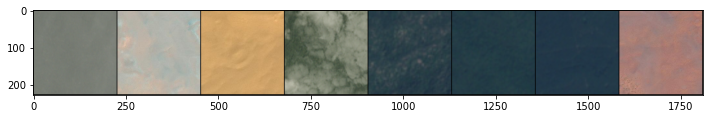

In [4]:
train_dl = torch.utils.data.DataLoader(train_data,batch_size=8,shuffle=False)
test_dl = torch.utils.data.DataLoader(test_data,batch_size=8,shuffle=False)
def show_trans_img(dataset):
    batch = next(iter(dataset))
    img,la = batch
    
    grid = torchvision.utils.make_grid(img,nrow=8)
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print("labels:",la)
    
show_trans_img(test_dl)
    

## Modeling 

In [6]:
def  outshape_conv2d(hin,win,conv,pool=2):
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation 
    
    hout = np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout = np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

    

In [159]:
import gc

 #delete unnecessary variables to avoid erro thanks to stack over flow :)
gc.collect()
torch.cuda.empty_cache()

## ResNet :)


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [6]:
num_class = 4
epochs = 5
batch_size = 8
learning_rate = 0.01

layers=[3, 4, 6, 3]
model = ResNet(ResidualBlock, layers)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate,weight_decay=0.001,momentum=0.9)

total_step = len(train_dl)

In [7]:
from torchsummary import summary

summary(model,(3,224,224))

# for i,l in train_dl:
#     print(i.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3         [-1, 64, 224, 224]          36,864
       BatchNorm2d-4         [-1, 64, 224, 224]             128
            Conv2d-5         [-1, 64, 224, 224]          36,864
       BatchNorm2d-6         [-1, 64, 224, 224]             128
     ResidualBlock-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,864
       BatchNorm2d-9         [-1, 64, 224, 224]             128
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
    ResidualBlock-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,864
      BatchNorm2d-14         [-1, 64, 2

## Training

In [11]:
import gc 

for e in range(1):
    for i ,(img,lab) in tqdm(enumerate(train_dl)):
        img, lab = img.cuda(), lab.cuda()  
        img = img.to(device)
        lab = lab.to(device)
        
        outputs = model(img)
        loss = loss_fn(outputs,lab)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        del img,lab,outputs
        torch.cuda.empty_cache()
        gc.collect()
    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(e+1, e, loss.item()))

564it [15:23,  1.64s/it]

Epoch [1/0], Loss: 0.7913


## Testing 


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(test_dl):
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on  test images: {100 * correct // total} %')

100%|██████████| 141/141 [01:01<00:00,  2.28it/s]

Accuracy of the network on  test images: 76 %
